In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.metrics import mean_squared_error

# 0.Nettoyage et Preparation des Donnees

In [10]:
sns.set(style="whitegrid")
df = pd.read_csv("options_KR.csv", parse_dates=["Date"], index_col="Date")
df["For_KOSPI_Netbuying_Amount"] = df["For_KOSPI_Netbuying_Amount"].apply(
    lambda x: int(float(x))
)
predictors = df.columns[1:].tolist()
df = pd.get_dummies(df, columns=["Day_of_a_week"])
predictors = df.columns[1:].tolist()

RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))


def split_time_dataset(X, y, train_ratio):
    assert X.shape[0] == len(y)

    n = X.shape[0]
    index = round(n * train_ratio)

    X_train, X_test = X.iloc[:index,], X.iloc[index:,]
    y_train, y_test = y[:index], y[index:]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_time_dataset(df[predictors], df["VKOSPI"], 0.8)
RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

# 2.Utiliser **LightGBM** 
pour prédire des valeurs et évaluer la performance du modèle à l'aide de métriques telles que RMSE et R².

In [11]:
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.metrics import mean_squared_error, r2_score


# Fonction d'évaluation des performances 
def evaluate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2


RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

def print_performance(y_true, y_pred):
    print(f"RMSE: {RMSE(y_true, y_pred):.2f}")
    print(f"Mean Value: {y_true.mean():.2f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")


model = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42, verbose=-1)  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print_performance(y_test, y_pred)

result = X_test.copy()
result["y_true"] = y_test
result["y_pred"] = y_pred
print(result.head())

RMSE: 2.68
Mean Value: 14.74
R2: -0.1498
            KOSPI200  Open_interest  For_KOSPI_Netbuying_Amount  \
Date                                                              
2017-09-25    316.71        2608858                -33255549625   
2017-09-26    316.40        2683826               -377000000000   
2017-09-27    314.29        2751479               -281000000000   
2017-09-28    313.82        2785810               -129000000000   
2017-09-29    313.85        2812364                 31843719202   

            For_Future_Netbuying_Quantity  For_Call_Netbuying_Quantity  \
Date                                                                     
2017-09-25                           1634                         5194   
2017-09-26                           2284                        -2663   
2017-09-27                          -3936                        -5865   
2017-09-28                           2652                        -7689   
2017-09-29                           4500    

# 3.Explorer l'impact des paramètres 
n_estimators (nombre d'arbres) et learning_rate sur la performance du modèle.

Meilleurs paramètres pour le learning rate et le nombre d'arbres :
{'n_estimators': 150, 'learning_rate': 0.01}
Minimum RMSE : 2.54


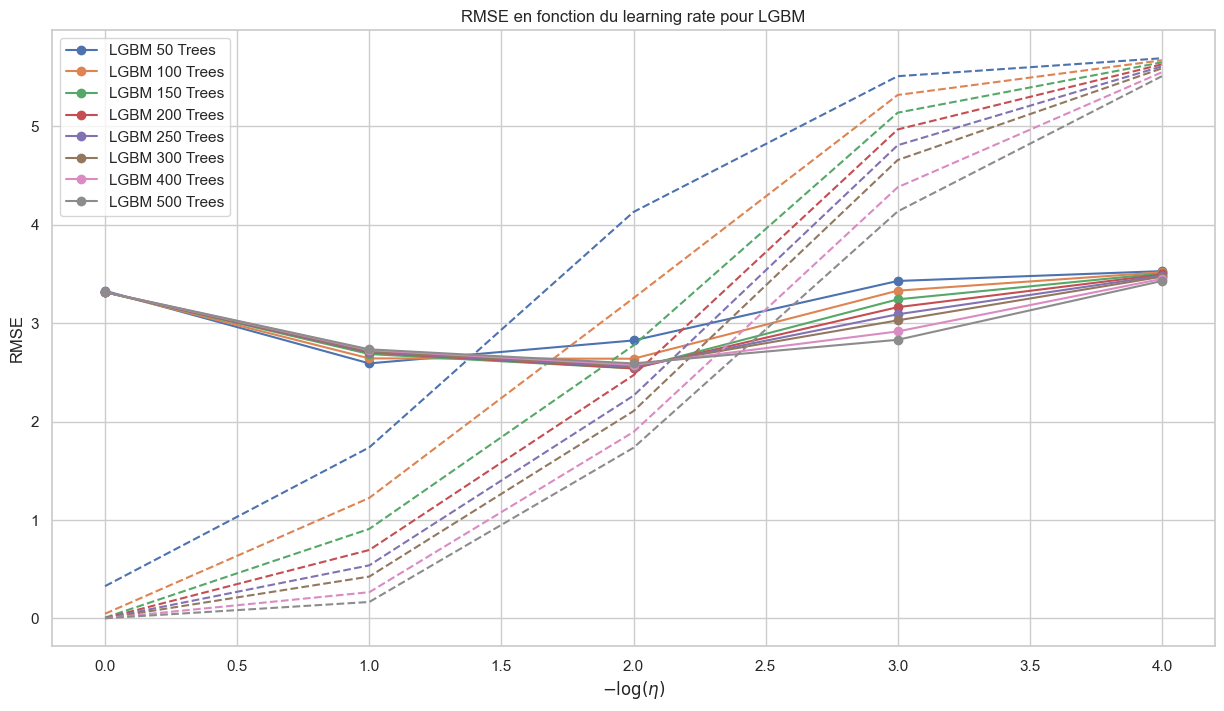

In [12]:
# Tester différents learning rate et nombres d'arbres de décision
performances = []
n_estimators_options = [50, 100, 150, 200, 250, 300, 400, 500]
learning_rate_options = [10**(-power) for power in range(0, 5)]

best_rmse = float("inf")
best_params = {}


for n_estimators in n_estimators_options:
    performance = {
        "Trees": n_estimators,
        "performances_train": [],
        "performances_test": []
    }
    for learning_rate in learning_rate_options:
        
        model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1)
        model.fit(X_train, y_train)

        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        
        train_rmse = RMSE(y_train, y_pred_train)
        test_rmse = RMSE(y_test, y_pred_test)

        # Ajout des résultats de performance
        performance["performances_train"].append(train_rmse)
        performance["performances_test"].append(test_rmse)

        
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_params = {
                "n_estimators": n_estimators,
                "learning_rate": learning_rate
            }

    performances.append(performance)

# Affichage des meilleurs paramètres et RMSE
print("Meilleurs paramètres pour le learning rate et le nombre d'arbres :")
print(best_params)
print(f"Minimum RMSE : {best_rmse:.2f}")

# Visualisation de la relation entre le learning rate et le RMSE
plt.figure(figsize=(15, 8))
learning_rate_powers = -np.log10(learning_rate_options)


for index, performance in enumerate(performances):
    color = sns.color_palette()[index]
    plt.plot(learning_rate_powers, performance["performances_test"], 'o-', label=f"LGBM {performance['Trees']} Trees", color=color)
    plt.plot(learning_rate_powers, performance["performances_train"], '--', color=color)

plt.xlabel(r"$-\log(\eta)$")
plt.ylabel("RMSE")
plt.title("RMSE en fonction du learning rate pour LGBM")
plt.legend()
plt.show()

# 4.Tester différents max_depth
Analyser l'impact de la profondeur maximale des arbres (max_depth) sur les performances du modèle.

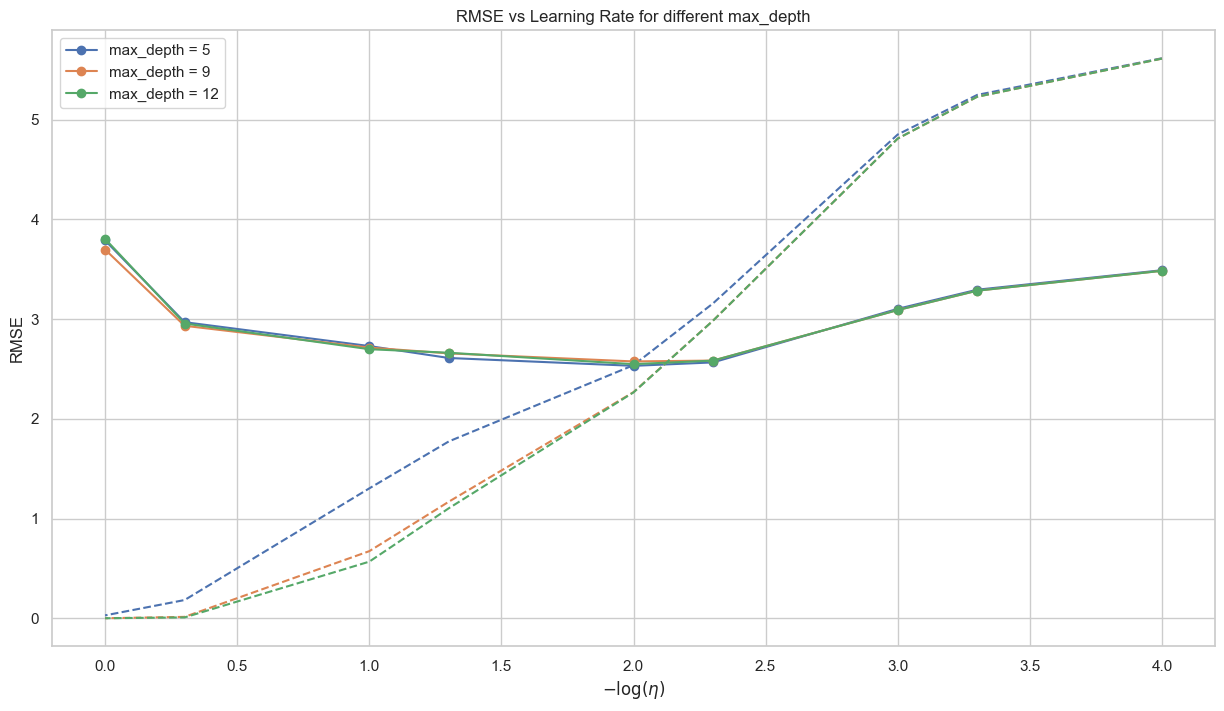

In [ ]:
# Tester différents max_depth 
learning_rates = [10**(-power) for power in range(0, 3)] + [5 * 10**(-power) for power in range(1, 3)]
learning_rates.sort()

max_depth_values = [5, 9, 12]


def compute_performance(learning_rates, parameter_name, parameter_values, **parameters):
    performances = []
    best_rmse = float("inf")
    best_params = {}

    for parameter_value in parameter_values:
        train_rmse = []
        test_rmse = []
        for learning_rate in learning_rates:
            parameters["learning_rate"] = learning_rate
            parameters[parameter_name] = parameter_value
            model = LGBMRegressor(**parameters, verbose=-1)  
            model.fit(X_train, y_train)

            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

            rmse_train = RMSE(y_train, y_pred_train)
            rmse_test = RMSE(y_test, y_pred_test)

            train_rmse.append(rmse_train)
            test_rmse.append(rmse_test)

            if rmse_test < best_rmse:
                best_rmse = rmse_test
                best_params = {
                    parameter_name: parameter_value,
                    "learning_rate": learning_rate
                }

        performances.append({
            parameter_name: parameter_value,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse
        })

    print(f"Meilleurs paramètres pour {parameter_name} et learning rate:")
    print(best_params)
    print(f"Minimum RMSE: {best_rmse:.2f}")
    return performances

performances = compute_performance(learning_rates=learning_rates, parameter_name="max_depth", parameter_values=max_depth_values, n_estimators=250)

# Visualiser la relation entre max_depth et le learning rate
plt.figure(figsize=(15, 8))
learning_rate_powers = -np.log10(learning_rates)

for index, performance in enumerate(performances):
    color = sns.color_palette()[index]
    plt.plot(learning_rate_powers, performance["test_rmse"], 'o-', label=f"max_depth = {performance['max_depth']}", color=color)
    plt.plot(learning_rate_powers, performance["train_rmse"], '--', color=color)

plt.xlabel(r"$-\log(\eta)$")
plt.ylabel("RMSE")
plt.title("RMSE en fonction du learning rate pour différents max_depth")
plt.legend()
plt.show()


<Figure size 1500x800 with 0 Axes>

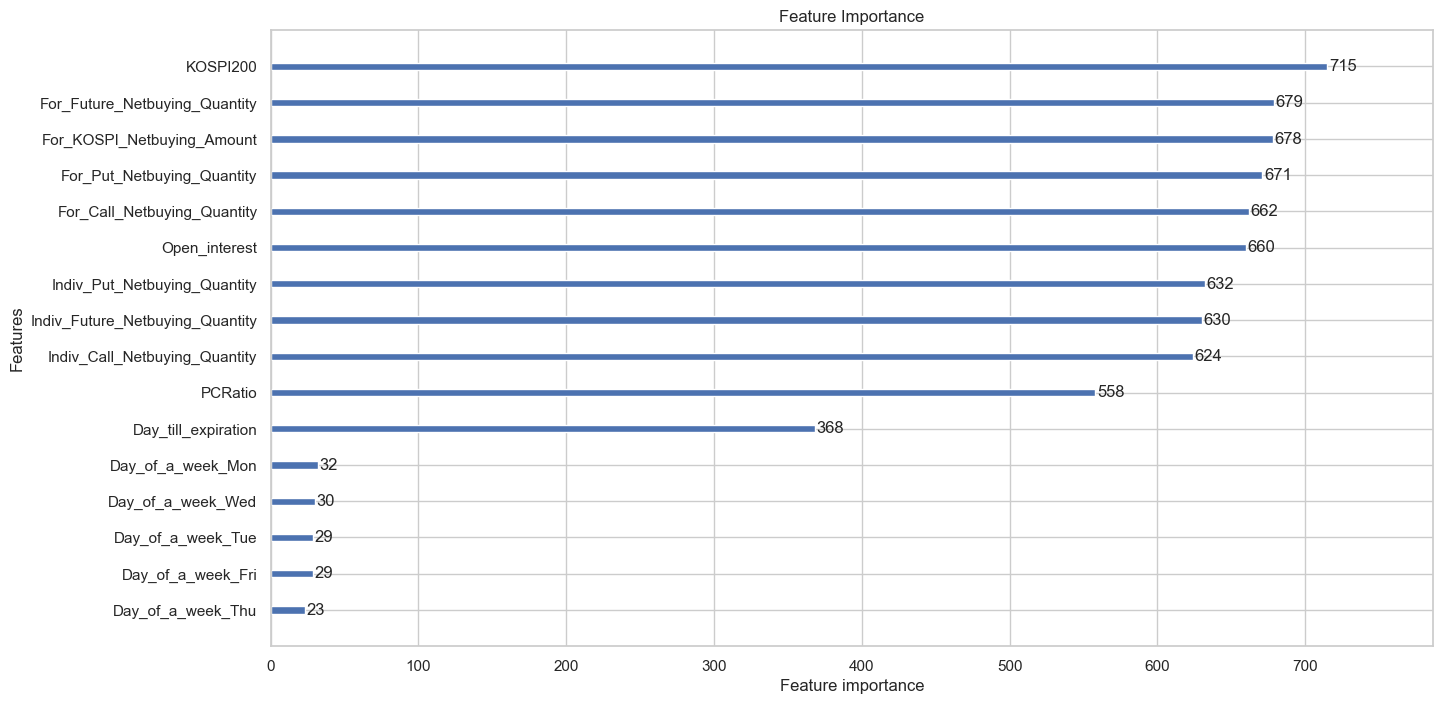

In [ ]:
# Analyse de l'importance des caractéristiques 
model = LGBMRegressor(n_estimators=250, learning_rate=0.5, max_depth=9, verbose=-1) 
model.fit(X_train, y_train)

plt.figure(figsize=(15, 8))
plot_importance(model, max_num_features=10, importance_type="gain")
plt.title("Importance des caractéristiques")
plt.show()

## Meilleurs paramètres

n_estimators: 500, learning_rate: 0.0001, max_depth: 12
